In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spreg import OLS
from libpysal.weights import Kernel
from esda.moran import Moran
import statsmodels.api as sm

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/daily.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond_daily.csv')

In [3]:
AQMS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7665 entries, 0 to 7664
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  7665 non-null   object 
 1   Value     7665 non-null   float64
 2   Site      7665 non-null   object 
dtypes: float64(1), object(2)
memory usage: 179.8+ KB


In [4]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   siteid    21 non-null     object  
 1   sitename  21 non-null     object  
 2   geometry  21 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 632.0+ bytes


In [5]:
cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  365 non-null    object 
 1   bp_mean   365 non-null    float64
 2   tmp_mean  365 non-null    float64
 3   rh_mean   365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [6]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)
loc_gdf.head()

,sitename,geometry,buffer_1km
siteid,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18..."


In [7]:
# Get all green spaces

Gsp=Gsp_gdf['geometry'].unary_union

In [8]:
# Set buffer zones for every road (50m)

Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)

In [9]:
# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [10]:
# Get all road buffer zones

Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [11]:
# Get all near-road green spaces

nRd_Gsp=Gsp.intersection(Rd_buffer)

In [12]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [13]:
# get all roads, green spaces and near-road green spaces in buffer zones around every sites
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp))

21 21 21


In [14]:
# append them into the dataframe
loc_gdf['Road']=Rd_shp
loc_gdf['GreenSpace']=Gsp_shp
loc_gdf['NR_GreenSpace']=nRd_Gsp_shp
loc_gdf=loc_gdf.set_geometry('Road').set_geometry('GreenSpace').set_geometry('NR_GreenSpace')
loc_gdf

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace
siteid,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,..."
CT3,City of London - Sir John Cass School,POINT (533480.243 181186.837),"POLYGON ((534480.243 181186.837, 534475.427 18...",MULTILINESTRING Z ((533123.210 180253.779 0.00...,"MULTIPOLYGON Z (((534480.226 181186.502 0.000,...","MULTIPOLYGON Z (((534480.226 181186.502 0.000,..."
CR8,Croydon - Norbury Manor,POINT (530322.972 169553.770),"POLYGON ((531322.972 169553.770, 531318.157 16...",MULTILINESTRING Z ((530343.828 168554.795 0.00...,"MULTIPOLYGON Z (((530029.704 168597.897 0.000,...","MULTIPOLYGON Z (((530029.704 168597.897 0.000,..."
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,..."
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,..."


In [15]:
# london boundary
london=gpd.read_file('data/london_boundary.shp')

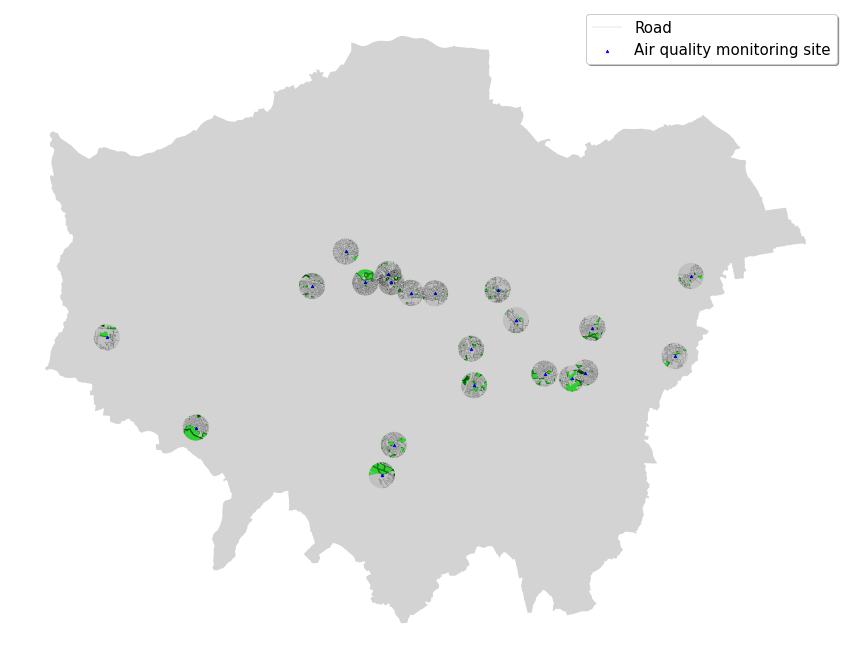

In [16]:
# visualise all the sites on the map
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to others.

In [17]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [18]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis
siteid,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933


In [19]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                                 \
      count       mean       std       min       25%        50%        75%   
Site                                                                         
BL0   365.0  10.773266  8.609044  2.779167  5.454167   7.479167  12.054167   
CD9   365.0  13.636306  8.786610  4.220833  8.229167  10.462500  15.316667   
GB0   365.0  12.170311  7.673069  3.975000  7.300000   9.683333  13.829167   
GR4   365.0  10.887170  8.333161  2.512500  6.041667   8.158333  11.721337   

                 
            max  
Site             
BL0   48.720833  
CD9   53.466667  
GB0   46.891667  
GR4   62.054167

In [20]:
# revmove them from the list
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [21]:
# get the area of each buffer zone
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [22]:
# get percentages of green space and near-road green space areas 
loc_gdf['pct_Gsp_area']=loc_gdf['GreenSpace'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nR_Gsp_area']=loc_gdf['NR_GreenSpace'].area/loc_gdf['buffer_area'] # percentage of near road gsp area

In [23]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19 entries, BX9 to MY7
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sitename         19 non-null     object  
 1   geometry         19 non-null     geometry
 2   buffer_1km       19 non-null     geometry
 3   Road             19 non-null     geometry
 4   GreenSpace       19 non-null     geometry
 5   NR_GreenSpace    19 non-null     geometry
 6   min_dis          19 non-null     float64 
 7   buffer_area      19 non-null     float64 
 8   pct_Gsp_area     19 non-null     float64 
 9   pct_nR_Gsp_area  19 non-null     float64 
dtypes: float64(4), geometry(5), object(1)
memory usage: 1.6+ KB


In [24]:
# merge PM reading and site geogemetry data
df=pd.merge(AQMS_df,loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 0 to 7664
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DateTime         6935 non-null   object  
 1   Value            6935 non-null   float64 
 2   Site             6935 non-null   object  
 3   sitename         6935 non-null   object  
 4   geometry         6935 non-null   geometry
 5   buffer_1km       6935 non-null   geometry
 6   Road             6935 non-null   geometry
 7   GreenSpace       6935 non-null   geometry
 8   NR_GreenSpace    6935 non-null   geometry
 9   min_dis          6935 non-null   float64 
 10  buffer_area      6935 non-null   float64 
 11  pct_Gsp_area     6935 non-null   float64 
 12  pct_nR_Gsp_area  6935 non-null   float64 
dtypes: float64(5), geometry(5), object(3)
memory usage: 758.5+ KB


In [25]:
# drop irrelevant columns
df.drop(['sitename','buffer_1km','Road','GreenSpace','NR_GreenSpace','min_dis','buffer_area'],
        axis=1,inplace=True)

<AxesSubplot:>

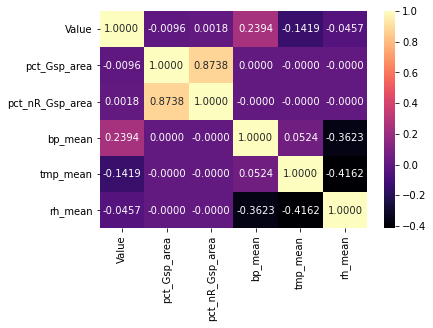

In [26]:
# check correlation between PM data and the conditional variables
sns.heatmap(df.merge(cond,how='left',on='DateTime').corr(),cmap='magma',annot=True,
            fmt='0.4f')

In [27]:
# prepare variables for the OLS model
Y=df['Value'].values
X=np.tile(cond[['bp_mean','tmp_mean']].values,(19,1))
print(X.shape,Y.shape)

(6935, 2) (6935,)


In [28]:
# fit a OLS model
m_multi=sm.OLS(Y,X)
m_multi_fit=m_multi.fit()
print(m_multi_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              7104.
Date:                Mon, 07 Mar 2022   Prob (F-statistic):                        0.00
Time:                        14:27:30   Log-Likelihood:                         -24530.
No. Observations:                6935   AIC:                                  4.906e+04
Df Residuals:                    6933   BIC:                                  4.908e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
# kernel weight matrix for 19 sites
weight=Kernel.from_dataframe(loc_gdf,geom_col='geometry',function='gaussian')

In [30]:
# covert the DateTime column to numpy.datetime variable
df['Date']=pd.to_datetime(df['DateTime'])

In [31]:
# moran's Is for PM readings on different days
moran=[]
for date in df['Date'].unique():
    mi=Moran(df[df['Date']==date].Value.values,weight)
    moran.append(mi.I)
len(moran)

365

<AxesSubplot:>

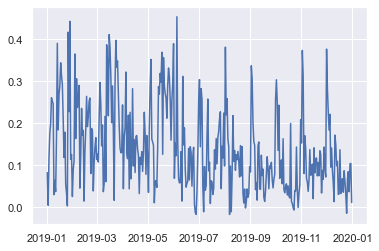

In [32]:
# change of moran's I during the year of 2019
sns.set_theme(style='darkgrid')
sns.lineplot(x=df['Date'].unique(),y=moran)

In [33]:
# global moran's I for pct of gsp
moran_gsp=Moran(loc_gdf['pct_Gsp_area'].values,weight)
round(moran_gsp.I,5)

0.22754

In [34]:
# global moran's I for pct of near-road gsp
moran_nR=Moran(loc_gdf['pct_nR_Gsp_area'].values,weight)
round(moran_nR.I,5)

0.10186

In [35]:
# merge with conditional variables
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 0 to 6934
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateTime         6935 non-null   object        
 1   Value            6935 non-null   float64       
 2   Site             6935 non-null   object        
 3   geometry         6935 non-null   geometry      
 4   pct_Gsp_area     6935 non-null   float64       
 5   pct_nR_Gsp_area  6935 non-null   float64       
 6   Date             6935 non-null   datetime64[ns]
 7   bp_mean          6935 non-null   float64       
 8   tmp_mean         6935 non-null   float64       
 9   rh_mean          6935 non-null   float64       
dtypes: datetime64[ns](1), float64(6), geometry(1), object(2)
memory usage: 596.0+ KB


In [36]:
# set up a new column for month information
df['month']=df['Date'].dt.month

In [37]:
# check data types
df.dtypes

DateTime                   object
Value                     float64
Site                       object
geometry                 geometry
pct_Gsp_area              float64
pct_nR_Gsp_area           float64
Date               datetime64[ns]
bp_mean                   float64
tmp_mean                  float64
rh_mean                   float64
month                       int64
dtype: object

<AxesSubplot:xlabel='month'>

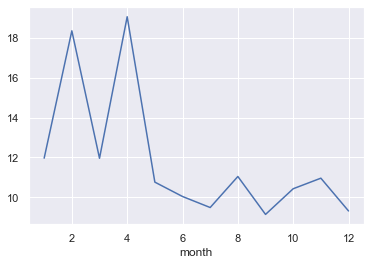

In [39]:
# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [40]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].copy()
low=df[~df['month'].isin([1,2,3,4])].copy()

In [42]:
print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (2280, 11)
low: (4655, 11)


In [65]:
Y=high['Value'].values
sum((Y-Y.mean())/Y.std())

6.467049118441537e-13

In [64]:
X=high[vars].values
(X-X.mean(axis=0))/X.std(axis=0)

array([1.06359366e-13, 3.20410365e-13, 1.09501297e-11, 4.37871961e-13,
       6.51964593e-13])

In [92]:
vars=['pct_Gsp_area','pct_nR_Gsp_area','bp_mean','tmp_mean','rh_mean']

Y=high['Value'].values
Y=Y/np.linalg.norm(Y,axis=0)

X=high[vars].values
X=X/np.linalg.norm(X,axis=0)

m_high=OLS(Y,X)
print(m_high.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        2280
Mean dependent var  :      0.0169                Number of Variables   :           6
S.D. dependent var  :      0.0124                Degrees of Freedom    :        2274
R-squared           :      0.0776
Adjusted R-squared  :      0.0756
Sum squared residual:       0.321                F-statistic           :     38.2541
Sigma-square        :       0.000                Prob(F-statistic)     :   8.374e-38
S.E. of regression  :       0.012                Log likelihood        :    6874.686
Sigma-square ML     :       0.000                Akaike info criterion :  -13737.372
S.E of regression ML:      0.0119                Schwarz criterion     :  -13702.980

-----------------------------------------------------------------------------

In [83]:
X

array([[2.54622690e-02, 1.95907148e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.60233459e-02, 1.52154663e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.27604875e-01, 3.86575479e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.16091079e-01, 5.81496714e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [2.67696267e-02, 1.04320779e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.34544446e-01, 8.06241128e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.34255650e-01, 5.86272925e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [4.77353404e-02, 2.12493258e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.16565167e-01, 3.70169369e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [6.19152446e-02, 5.37136085e-02, 1.02986458e+03, 9.36648332e+00,
        7.57842518e+01],
       [1.98268030e-01, 1.0043

In [82]:
loc_gdf

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis,buffer_area,pct_Gsp_area,pct_nR_Gsp_area
siteid,,,,,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,...",6262.058504,3.136548e+06,0.062358,0.022665
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439,3.136548e+06,0.052833,0.042514
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
CT3,City of London - Sir John Cass School,POINT (533480.243 181186.837),"POLYGON ((534480.243 181186.837, 534475.427 18...",MULTILINESTRING Z ((533123.210 180253.779 0.00...,"MULTIPOLYGON Z (((534480.226 181186.502 0.000,...","MULTIPOLYGON Z (((534480.226 181186.502 0.000,...",1858.165217,3.136548e+06,0.016023,0.015215
CR8,Croydon - Norbury Manor,POINT (530322.972 169553.770),"POLYGON ((531322.972 169553.770, 531318.157 16...",MULTILINESTRING Z ((530343.828 168554.795 0.00...,"MULTIPOLYGON Z (((530029.704 168597.897 0.000,...","MULTIPOLYGON Z (((530029.704 168597.897 0.000,...",2509.228941,3.136548e+06,0.127605,0.038658
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933,3.136548e+06,0.116091,0.058150
GN6,Greenwich - John Harrison Way,POINT (539685.230 179119.938),"POLYGON ((540685.230 179119.938, 540680.415 17...",MULTILINESTRING Z ((539715.046 178121.403 0.00...,"MULTIPOLYGON Z (((539996.407 178170.473 0.000,...","MULTIPOLYGON Z (((539996.407 178170.473 0.000,...",2715.809659,3.136548e+06,0.026770,0.010432
GN3,Greenwich - Plumstead High Street,POINT (545560.664 178526.019),"POLYGON ((546560.664 178526.019, 546555.849 17...",MULTILINESTRING Z ((545635.000 177544.000 0.00...,"MULTIPOLYGON Z (((545902.127 177587.391 0.000,...","MULTIPOLYGON Z (((545902.127 177587.391 0.000,...",3473.750339,3.136548e+06,0.134544,0.080624


In [44]:
from sklearn.linear_model import LinearRegression

reg=LinearRegression().fit(X,Y)
reg.score(X,Y)

0.07758598838595276

<AxesSubplot:xlabel='Date'>

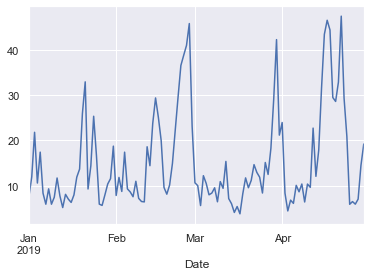

In [54]:
high.groupby('Date').mean()['Value'].plot()

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 0 to 6934
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateTime         6935 non-null   object        
 1   Value            6935 non-null   float64       
 2   Site             6935 non-null   object        
 3   geometry         6935 non-null   geometry      
 4   pct_Gsp_area     6935 non-null   float64       
 5   pct_nR_Gsp_area  6935 non-null   float64       
 6   Date             6935 non-null   datetime64[ns]
 7   bp_mean          6935 non-null   float64       
 8   tmp_mean         6935 non-null   float64       
 9   rh_mean          6935 non-null   float64       
 10  month            6935 non-null   int64         
dtypes: datetime64[ns](1), float64(6), geometry(1), int64(1), object(2)
memory usage: 650.2+ KB


In [98]:
df['week']=df['Date'].dt.isocalendar().week

In [104]:
weekly=df.groupby(['Site','week']).mean().reset_index()
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Site             988 non-null    object 
 1   week             988 non-null    int64  
 2   Value            988 non-null    float64
 3   pct_Gsp_area     988 non-null    float64
 4   pct_nR_Gsp_area  988 non-null    float64
 5   bp_mean          988 non-null    float64
 6   tmp_mean         988 non-null    float64
 7   rh_mean          988 non-null    float64
 8   month            988 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 69.6+ KB


In [105]:
weekly.drop('month',axis=1,inplace=True)

In [107]:
weekly[['Value']+vars].corr().round(4)

,Value,pct_Gsp_area,pct_nR_Gsp_area,bp_mean,tmp_mean,rh_mean
Value,1.0000,-0.0147,0.0027,0.3885,-0.2056,-0.2820
pct_Gsp_area,-0.0147,1.0000,0.8738,0.0000,0.0000,-0.0000
pct_nR_Gsp_area,0.0027,0.8738,1.0000,0.0000,0.0000,-0.0000
bp_mean,0.3885,0.0000,0.0000,1.0000,0.0868,-0.4388
tmp_mean,-0.2056,0.0000,0.0000,0.0868,1.0000,-0.5006
rh_mean,-0.2820,-0.0000,-0.0000,-0.4388,-0.5006,1.0000


In [108]:
Y=weekly['Value'].values
Y=Y/np.linalg.norm(Y,axis=0)

X=weekly[vars].values
X=X/np.linalg.norm(X,axis=0)

m_weekly=OLS(Y,X,name_y='PM reading',name_x=vars)

print(m_weekly.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  PM reading                Number of Observations:         988
Mean dependent var  :      0.0288                Number of Variables   :           6
S.D. dependent var  :      0.0135                Degrees of Freedom    :         982
R-squared           :      0.2940
Adjusted R-squared  :      0.2904
Sum squared residual:       0.128                F-statistic           :     81.7707
Sigma-square        :       0.000                Prob(F-statistic)     :   7.867e-72
S.E. of regression  :       0.011                Log likelihood        :    3020.492
Sigma-square ML     :       0.000                Akaike info criterion :   -6028.983
S.E of regression ML:      0.0114                Schwarz criterion     :   -5999.609

-----------------------------------------------------------------------------

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 0 to 6934
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateTime         6935 non-null   object        
 1   Value            6935 non-null   float64       
 2   Site             6935 non-null   object        
 3   geometry         6935 non-null   geometry      
 4   pct_Gsp_area     6935 non-null   float64       
 5   pct_nR_Gsp_area  6935 non-null   float64       
 6   Date             6935 non-null   datetime64[ns]
 7   bp_mean          6935 non-null   float64       
 8   tmp_mean         6935 non-null   float64       
 9   rh_mean          6935 non-null   float64       
 10  month            6935 non-null   int64         
 11  week             6935 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(6), geometry(1), int64(1), object(2)
memory usage: 684.0+ KB


In [110]:
hourly=pd.read_csv('data/hourly.csv')
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Site      183960 non-null  object 
 1   Value     183960 non-null  float64
 2   DateTime  183960 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


In [111]:
hourly['DateTime']=pd.to_datetime(hourly['DateTime'])

<AxesSubplot:xlabel='DateTime'>

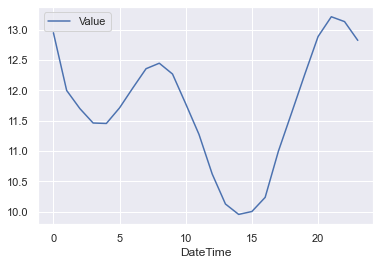

In [129]:
hourly.groupby(hourly['DateTime'].dt.hour).mean().plot()

<AxesSubplot:xlabel='DateTime'>

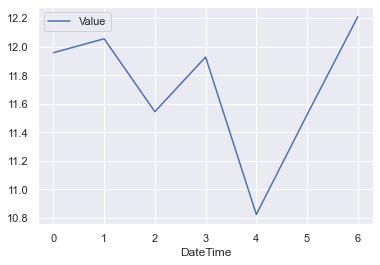

In [125]:
hourly.groupby(hourly['DateTime'].dt.dayofweek).mean().plot()

<AxesSubplot:xlabel='DateTime'>

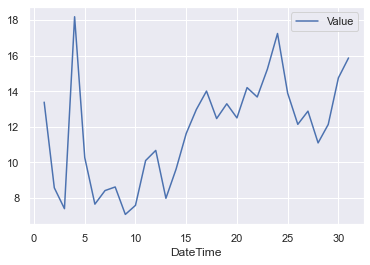

In [128]:
hourly.groupby(hourly['DateTime'].dt.day).mean().plot()